## Using Keras for Word Embedding as well as the LSTM

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://keras.io/getting-started/functional-api-guide/

In [24]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from keras.layers import Bidirectional, Dense, Dropout, Input, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from os.path import join

In [91]:
FEATURES_DIR = join("..", "feature_extraction", "feature_outputs")
DATA_FILES_DIR = join("..", "feature_extraction", "data_files")
chat_logs_filename = join(DATA_FILES_DIR, "gnue_irc_chat_logs_preprocessed.txt")
summarized_chat_date_partitions_filename = join(
    DATA_FILES_DIR, "summarized_chat_date_partitions_cumulative_count.csv"
)
summarized_chat_log_ids_filename = join(DATA_FILES_DIR, "summarized_chat_log_ids.csv")
summarized_chat_features_filename = join(FEATURES_DIR, "summarized_chats_features.csv")

In [4]:
summarized_chat_date_partitions = pd.read_csv(summarized_chat_date_partitions_filename)

In [5]:
summarized_chat_date_partitions.tail(8)

,min_log_id,date_of_log,chat_line_count,cumulative_count
19,473197,2001-11-07,1990,16079
20,495175,2001-11-13,1051,17130
21,497259,2001-11-14,536,17666
22,526307,2001-11-15,1053,18719
23,531627,2001-11-12,1348,20067
24,579591,2001-10-24,162,20229
25,586206,2001-10-23,165,20394
26,623684,2001-10-25,321,20715


In [6]:
index_for_validation_test_split = summarized_chat_date_partitions.tail(4)["cumulative_count"]
index_for_validation_test_split = index_for_validation_test_split.values[0]
index_for_train_validation_split = summarized_chat_date_partitions.tail(8)["cumulative_count"]
index_for_train_validation_split = index_for_train_validation_split.values[0]
print(index_for_train_validation_split)
print(index_for_validation_test_split)

16079
20067


In [7]:
# read in data using pandas
unnormalized_summarized_chat_features_df = pd.read_csv(summarized_chat_features_filename)

In [8]:
unnormalized_summarized_chat_features_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987539,2,0,0.0000,0.000432,0.003309,0.983457,0.281268,0
20711,624001,0.990654,4,0,0.0000,0.000801,0.006145,0.444846,0.127226,0
20712,624002,0.993769,7,0,0.5267,0.001122,0.008603,0.306102,0.087545,0
20713,624003,0.996885,0,0,0.4588,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,1,0,0.0000,0.000803,0.006161,2.205475,0.630764,0


## Normalize the chat features data

In [9]:
chat_data_max_values = unnormalized_summarized_chat_features_df.max()
chat_data_min_values = unnormalized_summarized_chat_features_df.min()
max_number_of_special_terms = chat_data_max_values.number_of_special_terms
max_sentence_length = chat_data_max_values.sentence_length
min_number_of_special_terms = chat_data_min_values.number_of_special_terms
min_sentence_length = chat_data_min_values.sentence_length
max_sentence_length

73.0

In [10]:
chat_log_df = unnormalized_summarized_chat_features_df.copy()
chat_log_df.sentence_length = (
    chat_log_df.sentence_length - min_sentence_length) / (
    max_sentence_length - min_sentence_length)
chat_log_df.number_of_special_terms = (
    chat_log_df.number_of_special_terms - min_number_of_special_terms) / (
    max_number_of_special_terms - min_number_of_special_terms)
chat_log_df.reset_index()
print(chat_log_df.sentence_length.head())
chat_log_df.iloc[-5:]

0    0.013699
1    0.178082
2    0.136986
3    0.068493
4    0.109589
Name: sentence_length, dtype: float64


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987539,0.027397,0.0,0.0000,0.000432,0.003309,0.983457,0.281268,0
20711,624001,0.990654,0.054795,0.0,0.0000,0.000801,0.006145,0.444846,0.127226,0
20712,624002,0.993769,0.095890,0.0,0.5267,0.001122,0.008603,0.306102,0.087545,0
20713,624003,0.996885,0.000000,0.0,0.4588,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,0.013699,0.0,0.0000,0.000803,0.006161,2.205475,0.630764,0


In [11]:
# Remove unneeded columns. Keep only normalized columns
columns_to_drop = ["log_id", "is_summary", "mean_tf_idf", "mean_tf_isf"]
chat_log_df = chat_log_df.drop(columns=columns_to_drop)
chat_log_df.tail()

,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
20710,0.987539,0.027397,0.0,0.0000,0.003309,0.281268
20711,0.990654,0.054795,0.0,0.0000,0.006145,0.127226
20712,0.993769,0.095890,0.0,0.5267,0.008603,0.087545
20713,0.996885,0.000000,0.0,0.4588,0.000000,0.000000
20714,1.000000,0.013699,0.0,0.0000,0.006161,0.630764


In [12]:
train_features_X = chat_log_df.iloc[:index_for_train_validation_split]
validation_features_X = chat_log_df.iloc[index_for_train_validation_split:index_for_validation_test_split]
test_features_X = chat_log_df.iloc[index_for_validation_test_split:]
train_features_X.tail()

assert train_features_X.shape[1] == test_features_X.shape[1] 
assert test_features_X.shape[1] == validation_features_X.shape[1] 
print(test_features_X.shape)
test_features_X.head()

(648, 6)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
20067,0.006173,0.232877,0.0,0.5994,0.004672,0.028675
20068,0.012346,0.027397,0.0,-0.2960,0.000686,0.315960
20069,0.018519,0.041096,0.0,-0.2960,0.003367,0.183785
20070,0.024691,0.000000,0.0,-0.4404,0.000000,0.000000
20071,0.030864,0.027397,0.0,0.0000,0.004243,0.272912


In [92]:
summarized_chat_log_ids = pd.read_csv(
    summarized_chat_log_ids_filename,
    names=["log_id", "is_summary"]
)

In [93]:
summarized_chat_log_ids.head()

,log_id,is_summary
0,85350,0
1,85351,0
2,85352,0
3,85353,0
4,85354,0


In [94]:
def get_summarized_chat_logs(chat_logs_filename, summarized_chat_log_ids):
    summarized_chat_log_ids = set(summarized_chat_log_ids)
    chats = []
    with open(chat_logs_filename) as chat_logs:
        line_number = 1
        for chat_log in chat_logs:
            if line_number in summarized_chat_log_ids:
                chats.append(chat_log)
            line_number += 1
    return chats

In [95]:
chat_logs = get_summarized_chat_logs(chat_logs_filename, summarized_chat_log_ids.log_id.values)
chat_logs[:5]

['great\n',
 'i dont recall you ever telling me what you do at your job\n',
 "and you probably can't be persuaded to tell me now.\n",
 'due to your persistant funkitude\n',
 'umm, he sits around on irc all day ;)\n']

In [17]:
# Create a Tokenizer Object
tokenizer = Tokenizer(
    num_words=None,
    filters="\n",
    lower = False, 
    split = ' '
)
tokenizer.fit_on_texts(chat_logs)

In [18]:
sequences = tokenizer.texts_to_sequences(chat_logs)

In [19]:
sequences[4]

[3099, 72, 4137, 300, 16, 584, 34, 309, 54]

In [20]:
word_indexes = tokenizer.index_word
def get_words_at_line_number(word_indexes, line_number):
    return " ".join(word_indexes[word] for word in sequences[line_number])

In [21]:
get_words_at_line_number(word_indexes, 2)

"and you probably can't be persuaded to tell me now."

In [22]:
tokenizer.index_word[356]

'language'

In [23]:
train_X = np.array(sequences[:index_for_train_validation_split])
validation_X = np.array(sequences[index_for_train_validation_split:index_for_validation_test_split])
test_X = np.array(sequences[index_for_validation_test_split:])
print(train_X.shape)
print(test_X.shape)
print(train_X[:1])
print(len(test_X))
test_X[-5:]

(16079,)
(648,)
[list([547])]
648


array([list([107, 18365]), list([128, 9, 31, 1456]),
       list([18366, 342, 36, 3591, 515, 29, 18367, 14]), list([14]),
       list([1454])], dtype=object)

In [24]:
# create a one hot encoding for the target column
chat_log_labels = to_categorical(summarized_chat_log_ids.is_summary)

train_y = chat_log_labels[:index_for_train_validation_split]
validation_y = chat_log_labels[index_for_train_validation_split:index_for_validation_test_split]
test_y = chat_log_labels[index_for_validation_test_split:]

In [26]:
test_y[85:90]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [27]:
# pad input sequences
max_chat_length = max(len(seq) for seq in sequences)
train_X = sequence.pad_sequences(train_X, maxlen=max_chat_length)
validation_X = sequence.pad_sequences(validation_X, maxlen=max_chat_length)
test_X = sequence.pad_sequences(test_X, maxlen=max_chat_length)

In [28]:
print(train_X.shape)
print(test_X.shape)
print(validation_X.shape)
print(validation_X[0])

(16079, 73)
(648, 73)
(3988, 73)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     4  1575    20   103    15     3 15875   908    12   125  1051
    14]


In [29]:
# create the model
top_words = 100000
embedding_vecor_length = 32
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_chat_length))
# model.add(Bidirectional(LSTM(100), input_shape=(max_chat_length, 1)))
# model.add((LSTM(100))
# model.add(Dense(2, activation='sigmoid'))



In [30]:
# This returns a tensor
# inputs = Input(shape=(784,))
# # a layer instance is callable on a tensor, and returns a tensor
# x = Dense(64, activation='relu')(inputs)
# x = Dense(64, activation='relu')(x)
# predictions = Dense(10, activation='softmax')(x)

# # This creates a model that includes
# # the Input layer and three Dense layers
# model = Model(inputs=inputs, outputs=predictions)
# model.compile(optimizer='rmsprop',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(data, labels)  # starts training

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [ ]:
# Sentence input: meant to receive sequences of `max_chat_length` integers, between 1 and `top_words`.
decoder_inputs = Input(shape=(max_chat_length,), dtype='int32', name='main_sentence_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
num_of_decoder_tokens = 512
x = Embedding(output_dim=num_of_decoder_tokens, input_dim=top_words, input_length=max_chat_length)(decoder_inputs)

# An LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
x, state_h, state_c = LSTM(32, return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x = Embedding(output_dim=num_of_decoder_tokens, input_dim=top_words)(decoder_inputs)
x = LSTM(top_words, return_sequences=True)(x, initial_state=encoder_states)
decoder_outputs = Dense(num_of_decoder_tokens, activation='softmax')(x)

# Define the model that will turn `encoder_input_data` & `decoder_input_data` 
# into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)nt q

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Compile model
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy'
)

In [ ]:
model.summary()

In [326]:
# Here we insert the auxiliary loss, allowing the LSTM and Embedding layer 
# to be trained smoothly even though the main loss will be much higher in the model.
auxiliary_output = Dense(32, name='aux_output')(lstm_out)

# At this point, we feed into the model our auxiliary input data by 
# concatenating it with the LSTM output
num_of_feature_columns = test_features_X.shape[1]
sentence_features_input = Input(shape=(num_of_feature_columns,), name='sentence_features_input')
merged_input_and_output = keras.layers.concatenate([lstm_out, sentence_features_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(merged_input_and_output)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(2, activation='sigmoid', name='main_output')(x)

In [327]:
# Define a model with two inputs and two outputs
merged_model = Model(
    inputs=[main_sentence_input, sentence_features_input], 
    outputs=[main_output, auxiliary_output]
)

We compile the model and assign a weight of 0.2 to the auxiliary loss. To specify different loss_weights or loss for each different output, you can use a list or a dictionary. Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.

In [328]:
merged_model.compile(
    # optimizer='rmsprop', 
    optimizer="adam",
    loss='categorical_crossentropy',
    loss_weights=[1., 0.2]
)
merged_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_sentence_input (InputLayer (None, 73)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 73, 512)      51200000    main_sentence_input[0][0]        
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 32)           69760       embedding_13[0][0]               
__________________________________________________________________________________________________
sentence_features_input (InputL (None, 6)            0                                            
__________________________________________________________________________________________________
concatenat

In [350]:
# Train the model by passing it lists of input arrays and target arrays
start = time.time()
merged_model_history = merged_model.fit(
    [train_X, train_features_X], 
    [train_y, train_y],
    # validation_split=0.2,
    validation_data=[
        [validation_X, validation_features_X], 
        [validation_y, validation_y]
    ],
    epochs=100, 
    batch_size=64
)
end = time.time()
print(end - start, " seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
16079/16079 [==============================] - 216s 13ms/step - loss: 0.0140 - main_output_loss: 0.0113 - aux_output_loss: 0.0136 - val_loss: 0.3317 - val_main_output_loss: 0.2863 - val_aux_output_loss: 0.2268
Epoch 2/100
16079/16079 [==============================] - 232s 14ms/step - loss: 0.0130 - main_output_loss: 0.0104 - aux_output_loss: 0.0128 - val_loss: 0.4219 - val_main_output_loss: 0.3702 - val_aux_output_loss: 0.2589
Epoch 3/100
16079/16079 [==============================] - 210s 13ms/step - loss: 0.0099 - main_output_loss: 0.0080 - aux_output_loss: 0.0097 - val_loss: 0.4401 - val_main_output_loss: 0.3871 - val_aux_output_loss: 0.2652
Epoch 4/100
16079/16079 [==============================] - 226s 14ms/step - loss: 0.0101 - main_output_loss: 0.0081 - aux_output_loss: 0.0098 - val_loss: 0.4425 - val_main_output_loss: 0.3894 - val_aux_output_loss: 0.2653
Epoch 5/100
16079/16079 [==============================] - 205s

Epoch 74/100
16079/16079 [==============================] - 196s 12ms/step - loss: 0.0042 - main_output_loss: 0.0035 - aux_output_loss: 0.0035 - val_loss: 0.7795 - val_main_output_loss: 0.6710 - val_aux_output_loss: 0.5424
Epoch 75/100
16079/16079 [==============================] - 195s 12ms/step - loss: 0.0041 - main_output_loss: 0.0034 - aux_output_loss: 0.0036 - val_loss: 0.8254 - val_main_output_loss: 0.7149 - val_aux_output_loss: 0.5525
Epoch 76/100
16079/16079 [==============================] - 197s 12ms/step - loss: 0.0041 - main_output_loss: 0.0034 - aux_output_loss: 0.0035 - val_loss: 0.8360 - val_main_output_loss: 0.7250 - val_aux_output_loss: 0.5551
Epoch 77/100
16079/16079 [==============================] - 197s 12ms/step - loss: 0.0041 - main_output_loss: 0.0033 - aux_output_loss: 0.0035 - val_loss: 0.8356 - val_main_output_loss: 0.7237 - val_aux_output_loss: 0.5595
Epoch 78/100
16079/16079 [==============================] - 197s 12ms/step - loss: 0.0039 - main_output_loss

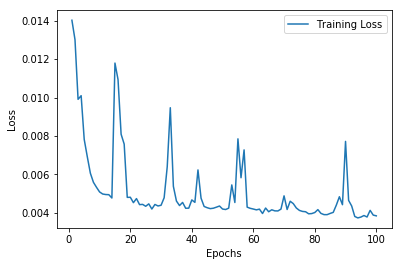

In [351]:
merged_model_loss_values = merged_model_history.history['loss']
merged_model_epochs = range(1, len(merged_model_loss_values)+1)

plt.plot(merged_model_epochs, merged_model_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [241]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 73, 32)            3200000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 402       
Total params: 3,306,802
Trainable params: 3,306,802
Non-trainable params: 0
_________________________________________________________________


In [250]:
start = time.time()
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(validation_X, validation_y), 
    epochs=100, 
    batch_size=64
)
end = time.time()
print(end-start, " seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
16079/16079 [==============================] - 30s 2ms/step - loss: 0.0165 - acc: 0.9940 - val_loss: 0.2794 - val_acc: 0.9431
Epoch 2/100
16079/16079 [==============================] - 32s 2ms/step - loss: 0.0153 - acc: 0.9947 - val_loss: 0.3203 - val_acc: 0.9361
Epoch 3/100
16079/16079 [==============================] - 35s 2ms/step - loss: 0.0132 - acc: 0.9952 - val_loss: 0.3589 - val_acc: 0.9348
Epoch 4/100
16079/16079 [==============================] - 34s 2ms/step - loss: 0.0123 - acc: 0.9959 - val_loss: 0.3636 - val_acc: 0.9366
Epoch 5/100
16079/16079 [==============================] - 39s 2ms/step - loss: 0.0110 - acc: 0.9963 - val_loss: 0.3835 - val_acc: 0.9318
Epoch 6/100
16079/16079 [==============================] - 33s 2ms/step - loss: 0.0097 - acc: 0.9969 - val_loss: 0.4015 - val_acc: 0.9258
Epoch 7/100
16079/16079 [==============================] - 30s 2ms/step - loss: 0.0104 - acc: 0.9963 - val_loss: 0.3782 - v

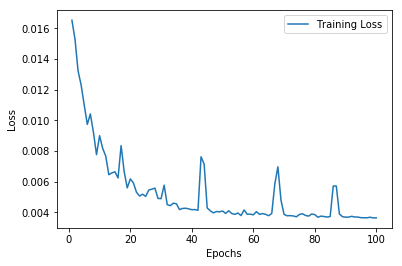

In [251]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [252]:
test_y_predictions = model.predict(test_X)
validation_y_predictions = model.predict(validation_X)

test_y_argmax = np.argmax(test_y,axis=1)
validation_y_argmax = np.argmax(validation_y,axis=1)

test_y_predictions_argmax = np.argmax(test_y_predictions, axis=1)
validation_y_predictions_argmax = np.argmax(validation_y_predictions, axis=1)

In [253]:
test_y_predictions[:10]

array([[9.99971867e-01, 0.00000000e+00],
       [9.97921944e-01, 1.43051147e-06],
       [9.99879599e-01, 2.98023224e-08],
       [9.99974608e-01, 0.00000000e+00],
       [9.99553978e-01, 8.94069672e-08],
       [9.99534607e-01, 1.49011612e-07],
       [5.84465206e-01, 3.55574489e-03],
       [9.98989344e-01, 5.06639481e-07],
       [9.05564904e-01, 3.40014696e-04],
       [9.80813026e-01, 1.14142895e-05]], dtype=float32)

In [254]:
test_y_predictions_argmax[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [255]:
test_y_argmax[:100]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [256]:
print(classification_report(test_y_argmax, test_y_predictions_argmax))
print(confusion_matrix(test_y_argmax, test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       619
           1       0.03      0.03      0.03        29

   micro avg       0.91      0.91      0.91       648
   macro avg       0.49      0.49      0.49       648
weighted avg       0.91      0.91      0.91       648

[[590  29]
 [ 28   1]]


In [257]:
print(classification_report(validation_y_argmax, validation_y_predictions_argmax))
print(confusion_matrix(validation_y_argmax, validation_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3872
           1       0.05      0.07      0.06       116

   micro avg       0.94      0.94      0.94      3988
   macro avg       0.51      0.52      0.51      3988
weighted avg       0.95      0.94      0.94      3988

[[3726  146]
 [ 108    8]]


In [208]:
y_actual_and_prediction = list(zip(test_y_argmax, test_y_predictions_argmax))
[y for i, y in enumerate(y_actual_and_prediction)][80:100]

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 1)]

In [225]:
log_ids_for_false_positives = []
log_ids_for_false_negatives = []
log_ids_for_true_positives = []
offset = index_for_validation_test_split
for index, value in enumerate(y_actual_and_prediction):
    if value == (0, 1):
        log_ids_for_false_positives.append(offset + index)
    elif value == (1, 0):
        log_ids_for_false_negatives.append(offset + index)
    elif value == (1,1):
        log_ids_for_true_positives.append(offset + index)
    
log_ids_for_false_positives = [index_for_validation_test_split + index for index, value in enumerate(y_actual_and_prediction) if value==(0, 1)]
log_ids_for_false_positives = [index_for_validation_test_split + index for index, value in enumerate(y_actual_and_prediction) if value==(0, 1)]
print(len(log_ids_for_false_positives))
print(len(log_ids_for_false_negatives))
print(len(log_ids_for_true_positives))
log_ids_for_false_positives[:10]

32
25
4


[20085, 20105, 20106, 20109, 20136, 20138, 20166, 20202, 20211, 20248]

In [224]:
for log_id in log_ids_for_false_positives:
    print(get_words_at_line_number(word_indexes, log_id))

or, for simplicity, print md5.new(string).digest() :)
BUT from geas/DBdriver.py:
def _make_passkey(self, user, passwd, random):
def _hexstr(self, s):
but when I update or co, it comes back
doesn't jamest have access to the cvs server?
either that or I customize interchange
(basically Python-based web application services
webware and GNUe might be interesting
real or imagined
any suggestions/comments?
doesn't it still have a usenet gateway?
and windows isnt a 'monitorless' operating system
there is an option to open as access as 97
i will get 97 up here pretty quick
and be much more 'official' than informal help
more official?
i.e. accountable
any non ie 5.0 or greater browser in fact
F*** YOU! No MSN for you.
this is really really incredible
I always wondered if gnuebot and bigbrother secretly fought in the background
either with win2k or kde&linux
the major hangup is of course.....drumroll....Office
what's it running per seat?
I strongly dislike cygwin's setup
if exists (select 1 from

In [226]:
for log_id in log_ids_for_true_positives:
    print(get_words_at_line_number(word_indexes, log_id))

pyro is an object system like what gcomm will be
the python email client
you should be able to access it via geas
and todo tool


In [227]:
for log_id in log_ids_for_false_negatives:
    print(get_words_at_line_number(word_indexes, log_id))

btw, why are ou guys calling this abstraction thingy GComm when Dave has a project called GNU Comm (GComm fr short)?
as far as I'm concerned, GComm is our internal package name... to the external world, it's GNUe Common
but that is a good point
by same guys that wrote pygmy
I need a production quality GNUe web shopping cart ;-)
anything is possible I know, but ideally we need to get ideas on some sort of php and GEAS interface
guess I'll just customize interchange.. hopefully actually have it done in a few days
our inventory package isn't completed
but if you have an inventory package
I know a web interface for GNUe Forms is in the works, but I'm sure you need something relatively quickly
madlocke was working on that, but as you probably know, he's been out of commission (sick) lately
a new release (feature wise) is probably about 3 or 4 weeks away since the db upgrade is going to be huge
I may make an interim bug fix/small feature release to get some of the email support down
but we a

#### Merged Model predictions

In [390]:
merged_test_y_predictions = merged_model.predict([test_X, test_features_X])
merged_validation_y_predictions = merged_model.predict([validation_X, validation_features_X])

merged_test_y_argmax = np.argmax(test_y,axis=1)
merged_validation_y_argmax = np.argmax(validation_y,axis=1)

merged_test_y_predictions_argmax = np.argmax(merged_test_y_predictions[1], axis=1)
merged_validation_y_predictions_argmax = np.argmax(merged_validation_y_predictions[1], axis=1)

In [391]:
print(merged_test_y_predictions_argmax[:100])
# print(merged_test_y_predictions[0])
print(merged_test_y_argmax[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0]


In [392]:
print(classification_report(merged_test_y_argmax, merged_test_y_predictions_argmax))
print(confusion_matrix(merged_test_y_argmax, merged_test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       619
           1       0.12      0.17      0.14        29

   micro avg       0.91      0.91      0.91       648
   macro avg       0.54      0.56      0.55       648
weighted avg       0.92      0.91      0.92       648

[[584  35]
 [ 24   5]]


In [393]:
print(classification_report(merged_validation_y_argmax, merged_validation_y_predictions_argmax))
print(confusion_matrix(merged_validation_y_argmax, merged_validation_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3872
           1       0.04      0.08      0.05       116

   micro avg       0.92      0.92      0.92      3988
   macro avg       0.50      0.51      0.50      3988
weighted avg       0.94      0.92      0.93      3988

[[3642  230]
 [ 107    9]]


In [3]:
data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]

In [97]:
word_tokenize(chat_logs[0].lower())

['great']

In [96]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(chat_logs)]

In [101]:
# max_epochs = 100
epochs = 40
vec_size = 20
alpha = 0.025
min_alpha = 0.00025
min_count = 2

# d2v_model = Doc2Vec(
#     size=vec_size,
#     alpha=alpha, 
#     min_alpha=min_alpha,
#     min_count=1,
#     dm =1
# )

d2v_model = Doc2Vec(vector_size=vec_size, min_count=min_count, epochs=epochs)

In [102]:
d2v_model.build_vocab(tagged_data)

In [103]:
%time d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

CPU times: user 27.5 s, sys: 8.59 s, total: 36.1 s
Wall time: 25.5 s


In [104]:
# for epoch in range(1, max_epochs + 1):
#     if epoch % 10 == 0:
#         print('iteration {0}'.format(epoch))
#     d2v_model.train(tagged_data,
#                 total_examples=d2v_model.corpus_count,
#                 epochs=d2v_model.epochs)
#     # decrease the learning rate
#     d2v_model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     d2v_model.min_alpha = d2v_model.alpha

In [105]:
d2v_model_filename = join(DATA_FILES_DIR, "doc2vec_model_10e")
d2v_model.save(d2v_model_filename)

In [106]:
loaded_d2v_model= Doc2Vec.load(d2v_model_filename)

In [113]:
test_data = word_tokenize("great".lower())
v1 = loaded_d2v_model.infer_vector(test_data, steps=epochs, alpha=alpha, min_alpha=min_alpha)
print("V1_infer", v1)

V1_infer [-0.01366701 -0.02549269  0.05739471  0.0522558  -0.04657764  0.02803853
 -0.02799745  0.06102591 -0.00764901 -0.01200486 -0.03226999 -0.0479882
 -0.00444868 -0.08236206 -0.02488584  0.03369953 -0.01224146  0.01957402
 -0.00447059 -0.02264629]


In [114]:
# to find most similar doc using tags
similar_doc = loaded_d2v_model.docvecs.most_similar(positive=[v1])
print(similar_doc)

[('17774', 0.8790661692619324), ('2020', 0.8772040605545044), ('8091', 0.8742135763168335), ('5032', 0.8663190603256226), ('14376', 0.8627078533172607), ('17677', 0.8586421012878418), ('1800', 0.8579913377761841), ('15340', 0.8560564517974854), ('4970', 0.8550747632980347), ('12065', 0.8510655164718628)]


In [88]:
# to find vector of doc in training data using tags or in other words, 
# printing the vector of document at index 1 in training data
vec_1 = loaded_d2v_model.docvecs['1']
print(vec_1)

[-0.02454001 -0.03144716 -0.02665585 -0.03217845 -0.03651904  0.02073577
  0.02193299 -0.001555   -0.00052284 -0.004239    0.01394437 -0.00971698
  0.00216964  0.00106866 -0.0232363   0.0085037  -0.00322458  0.01272531
  0.00839755 -0.02420341]


In [112]:
chat_logs[0]

'great\n'